## Initializing filters on known motifs

In the scenario where data is scarse, it is often useful to initialize the filters to some known position weights matrices (PWM's). That way, the model already starts with a parameter configuration much closes to the 'right' solution.

Concise provides access to (TODO how many) PWM databases for
- transcription factors from ENCODE
- rna-binding proteins from ATtrACT (1000 - TODO - show numbers).

### Find the motif of interest

#### Metadata

In [17]:
import concise.layers as cl
import keras.layers as kl
from keras.models import Model

In [2]:
# RBP PWM's
from concise.data import attract

dfa = attract.get_metadata()
dfa

,PWM_id,Gene_name,Gene_id,Mutated,Organism,Motif,Len,Experiment_description,Database,Pubmed,Experiment_description.1,Family,Score
0,519,3IVK,3IVK,no,Mus_musculus,GAAACA,6,X-RAY DIFFRACTION,PDB,19965478,X-RAY DIFFRACTION,NaN,1.000000**
1,574,3IVK,3IVK,no,Mus_musculus,UGGG,4,X-RAY DIFFRACTION,PDB,19965478,X-RAY DIFFRACTION,NaN,1.000000**
2,464,4KZD,4KZD,no,Mus_musculus,GAAAC,5,X-RAY DIFFRACTION,PDB,24952597,X-RAY DIFFRACTION,NaN,1.000000**
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4879,1396,HNRNPAB,ENSG00000197451,no,Homo_sapiens,AUAGCA,6,In vitro splicing assays,AEDB,12426391,other,RRM,1.000000**
4880,1397,HNRNPA1,ENSG00000135486,no,Homo_sapiens,UAGG,4,Immunoprecipitation;U...,AEDB,15506926,UV cross-linking,RRM,1.000000**
4881,1398,PTBP1,ENSG00000011304,no,Homo_sapiens,UUCUUC,6,In vivo splicing assa...,AEDB,14966131,UV cross-linking,RRM,1.000000**


In [4]:
# TF PWM's
from concise.data import encode

dfe = encode.get_metadata()
dfe

,motif_name,consensus
0,AFP_1,ATTAACTACAC
1,AHR::ARNT::HIF1A_1,TGCGTGCGG
2,AHR::ARNT_1,TAAGGGTTGCGTGCCC
...,...,...
2064,ZSCAN4_3,TGCACACACTGAAAA
2065,fake_AACGSSAA,AACGCCAA
2066,fake_AAGCSSAA,AAGCCCAA


Let's choose a PWMs of the PUM2 RBP in Human:

In [21]:
dfa_pum2 = dfa[dfa.Gene_name.str.match("PUM2") & \
               dfa.Organism.str.match("Homo_sapiens")]
dfa_pum2

,PWM_id,Gene_name,Gene_id,Mutated,Organism,Motif,Len,Experiment_description,Database,Pubmed,Experiment_description.1,Family,Score
2603,503,PUM2,ENSG00000055917,no,Homo_sapiens,UGUAAAUA,8,X-RAY DIFFRACTION,PDB,21397187,X-RAY DIFFRACTION,PUF,1.000000**
2604,361,PUM2,ENSG00000055917,no,Homo_sapiens,UGUACAUC,8,X-RAY DIFFRACTION,PDB,21397187,X-RAY DIFFRACTION,PUF,1.000000**
2605,514,PUM2,ENSG00000055917,no,Homo_sapiens,UGUAGAUA,8,X-RAY DIFFRACTION,PDB,21397187,X-RAY DIFFRACTION,PUF,1.000000**
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,107,PUM2,ENSG00000055917,no,Homo_sapiens,UGUAUAUA,8,PAR-clip,C,20371350,genome-wide in vivo i...,PUF,0.250000**
2614,107,PUM2,ENSG00000055917,no,Homo_sapiens,UGUACAUA,8,PAR-clip,C,20371350,genome-wide in vivo i...,PUF,0.250000**
2615,107,PUM2,ENSG00000055917,no,Homo_sapiens,UGUAGAUA,8,PAR-clip,C,20371350,genome-wide in vivo i...,PUF,0.250000**


#### Visualization

In [56]:
# Visualize the PUM2 Motifs from different experiments
from concise.utils.pwm import PWM
dfa_pum2_uniq = dfa_pum2[["Experiment_description", "PWM_id"]].drop_duplicates()
pwm_list = attract.get_pwm_list(dfa_pum2_uniq.PWM_id)

PWM_id: 503 ; Experiment_description: X-RAY DIFFRACTION


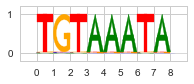

PWM_id: 361 ; Experiment_description: X-RAY DIFFRACTION


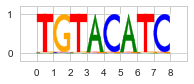

PWM_id: 514 ; Experiment_description: X-RAY DIFFRACTION


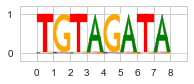

PWM_id: 116 ; Experiment_description: RIP-chip


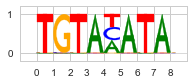

PWM_id: 129 ; Experiment_description: genome-wide in vivo immunoprecipitation


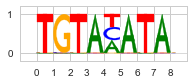

PWM_id: 107 ; Experiment_description: PAR-clip


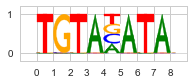

In [58]:
for i, pwm in enumerate(pwm_list):
    print("PWM_id:", pwm.name, "; Experiment_description:", dfa_pum2_uniq.Experiment_description.iloc[i])
    pwm.plotPWM(figsize=(3,1))

I'll select the PWM with id 129.

In [59]:
pwm_list = [pwm for pwm in pwm_list if pwm.name == "129"]

In [60]:
pwm_list

[PWM(name: 129, consensus: TGTAAATA)]

### Initialize the model with the motif

In [15]:
import concise.initializers as ci
in_dna = cl.InputDNA(seq_length=100, name="seq")
x = cl.ConvDNA(filters=15, 
               kernel_size=12, 
               kernel_initializer=ci.PSSMKernelInitializer(pwm_list),
               bias_initializer=ci.PSSMBiasInitializer(pwm_list),
               activation="relu")(in_dna)
x = kl.MaxPool1D(pool_size=4)(x)
x = kl.Flatten()(x)
x = kl.Dense(100, activation="relu")(x)
out = kl.Dense(1, activation="sigmoid")(x)
m = Model(in_dna, out)
m.compile("adam", loss="binary_crossentropy", metrics=["acc"])

This will set the filters of the first convolutional layer to the values of the position-specific scoring matrix (PSSM):

$$ pssm_{ij} = log \frac{pwm_{ij}}{b_j} \;,$$

where $b_j$ is the background probability of observing base $j$.

We add gaussian noise to each individual filter. Let's visualize the filters:

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt

import concise.layers as cl
import keras.layers as kl
import concise.initializers as ci
import concise.regularizers as cr
from keras.callbacks import EarlyStopping
from concise.preprocessing import encodeDNA
from keras.models import Model, load_model
from keras.optimizers import Adam

In [119]:
# get the data
def load(split="train", st=None):
    dt = pd.read_csv("../data/RBP/PUM2_{0}.csv".format(split))
    # DNA/RNA sequence
    xseq = encodeDNA(dt.seq) # list of sequences -> np.ndarray
    # response variable
    y = dt.binding_site.as_matrix().reshape((-1, 1)).astype("float")
    return {"seq": xseq}, y

train, valid, test = load("train"), load("valid"), load("test")

# deduce sequence length
seq_length = train[0]["seq"].shape[1]

In [120]:
# define the model
def model(train, filters=1, kernel_size=9, pwm_list=None, lr=0.001):
    seq_length = train[0]["seq"].shape[1]
    if pwm_list is None:
        kinit = "glorot_uniform"
        binit = "zeros"
    else:
        kinit = ci.PSSMKernelInitializer(pwm_list, add_noise_before_Pwm2Pssm=True)
        binit = "zeros"
        
    # sequence
    in_dna = cl.InputDNA(seq_length=seq_length, name="seq")
    x = cl.ConvDNA(filters=filters, 
                   kernel_size=kernel_size, 
                   activation="relu",
                   kernel_initializer=kinit,
                   bias_initializer=binit,
                   name="conv1")(in_dna)
    x = kl.AveragePooling1D(pool_size=4)(x)
    x = kl.Flatten()(x)
    
    x = kl.Dense(units=1)(x)
    m = Model(in_dna, x)
    m.compile(Adam(lr=lr), loss="binary_crossentropy", metrics=["acc"])
    return m

In [121]:
m_rand_init = model(train, filters=3, pwm_list=None) # random initialization
m_pwm_init = model(train, filters=3, pwm_list=pwm_list) # motif initialization

Random initialization:
filter index: 0


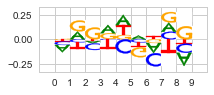

filter index: 1


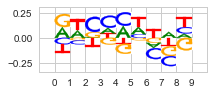

filter index: 2


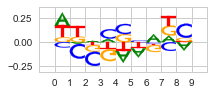

In [122]:
print("Random initialization:")
m_rand_init.get_layer("conv1").plot_weights(figsize=(3, 1.2))

Known PWM initialization:
filter index: 0


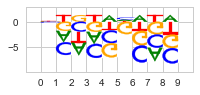

filter index: 1


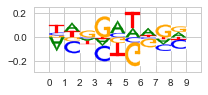

filter index: 2


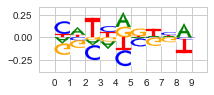

In [123]:
print("Known PWM initialization:")
m_pwm_init.get_layer("conv1").plot_weights(figsize=(3, 1.2))

In [124]:
m_rand_init.fit(train[0], train[1], epochs=50, validation_data=valid, 
                verbose=2,
                callbacks=[EarlyStopping(patience=5)])

Train on 17713 samples, validate on 4881 samples
Epoch 1/50
1s - loss: 0.5377 - acc: 0.7935 - val_loss: 0.5075 - val_acc: 0.7986
Epoch 2/50
1s - loss: 0.4948 - acc: 0.7954 - val_loss: 0.4951 - val_acc: 0.7988
Epoch 3/50
0s - loss: 0.4859 - acc: 0.7953 - val_loss: 0.4934 - val_acc: 0.7976
Epoch 4/50
0s - loss: 0.4752 - acc: 0.7948 - val_loss: 0.4815 - val_acc: 0.7978
Epoch 5/50
0s - loss: 0.4682 - acc: 0.7941 - val_loss: 0.4897 - val_acc: 0.7994
Epoch 6/50
0s - loss: 0.4609 - acc: 0.7956 - val_loss: 0.4534 - val_acc: 0.8002
Epoch 7/50
0s - loss: 0.4581 - acc: 0.7955 - val_loss: 0.4549 - val_acc: 0.7998
Epoch 8/50
1s - loss: 0.4494 - acc: 0.7967 - val_loss: 0.4425 - val_acc: 0.8002
Epoch 9/50
0s - loss: 0.4445 - acc: 0.7985 - val_loss: 0.4382 - val_acc: 0.8039
Epoch 10/50
0s - loss: 0.4442 - acc: 0.7992 - val_loss: 0.4340 - val_acc: 0.8025
Epoch 11/50
0s - loss: 0.4802 - acc: 0.8022 - val_loss: 0.4506 - val_acc: 0.7992
Epoch 12/50
0s - loss: 0.4422 - acc: 0.7991 - val_loss: 0.4325 - val_

In [125]:
m_pwm_init.fit(train[0], train[1], epochs=50, validation_data=valid, 
                verbose=2,
                callbacks=[EarlyStopping(patience=5)])

Train on 17713 samples, validate on 4881 samples
Epoch 1/50
1s - loss: 0.9121 - acc: 0.7811 - val_loss: 0.7350 - val_acc: 0.8089
Epoch 2/50
0s - loss: 0.6309 - acc: 0.8009 - val_loss: 0.4981 - val_acc: 0.8168
Epoch 3/50
0s - loss: 0.4828 - acc: 0.8149 - val_loss: 0.4632 - val_acc: 0.8181
Epoch 4/50
0s - loss: 0.4521 - acc: 0.8206 - val_loss: 0.4496 - val_acc: 0.8218
Epoch 5/50
0s - loss: 0.4309 - acc: 0.8246 - val_loss: 0.4399 - val_acc: 0.8254
Epoch 6/50
0s - loss: 0.4285 - acc: 0.8306 - val_loss: 0.4316 - val_acc: 0.8285
Epoch 7/50
0s - loss: 0.4077 - acc: 0.8333 - val_loss: 0.4228 - val_acc: 0.8330
Epoch 8/50
0s - loss: 0.3989 - acc: 0.8405 - val_loss: 0.4168 - val_acc: 0.8404
Epoch 9/50
0s - loss: 0.3923 - acc: 0.8432 - val_loss: 0.4183 - val_acc: 0.8396
Epoch 10/50
0s - loss: 0.3869 - acc: 0.8477 - val_loss: 0.4221 - val_acc: 0.8468
Epoch 11/50
0s - loss: 0.3825 - acc: 0.8543 - val_loss: 0.4059 - val_acc: 0.8545
Epoch 12/50
0s - loss: 0.3866 - acc: 0.8558 - val_loss: 0.4047 - val_

### Test-set performance

In [126]:
import concise.eval_metrics as cem

In [131]:
# performance on the test-set
# Random initialization
print("Random intiailzation auPR:", cem.auprc(test[1], m_rand_init.predict(test[0])))
# PWM initialization
print("Known PWM initialization auPR:", cem.auprc(test[1], m_pwm_init.predict(test[0])))

Random intiailzation auPR: 0.545485934968
Known PWM initialization auPR: 0.713402165756


### Filter visualization

filter index: 0


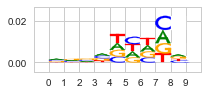

filter index: 1


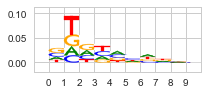

filter index: 2


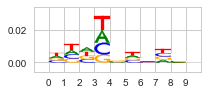

In [128]:
m_rand_init.get_layer("conv1").plot_weights(plot_type="motif_pwm_info", figsize=(3, 1.2))

filter index: 0


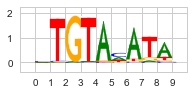

filter index: 1


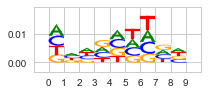

filter index: 2


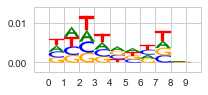

In [129]:
m_pwm_init.get_layer("conv1").plot_weights(plot_type="motif_pwm_info", figsize=(3, 1.2))

## Benefits of motif initialization

- Interpretatbility
  - we can use fewer filters and know that the major effect will be captured by the first filters
    - important when the effect of filters in some context (or interaction with other motifs)
- Better predictive performance & more stable training